In [165]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from math import sqrt

from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

# import seaborn as sns
# sns.set_style('white')
# sns.set_context("poster") #[poster, paper, talk, notebook]

font = {'size'   : 24}

mpl.rc('font', **font)

#### Station data Tuolumne

In [2]:
path = '/Users/meganmason491/Documents/research/sierra/data/stations/*.csv' #BSU
# path = '/Users/megmason/research/sierra/data/station/*0930.csv' #mac
flist = glob.glob(path)

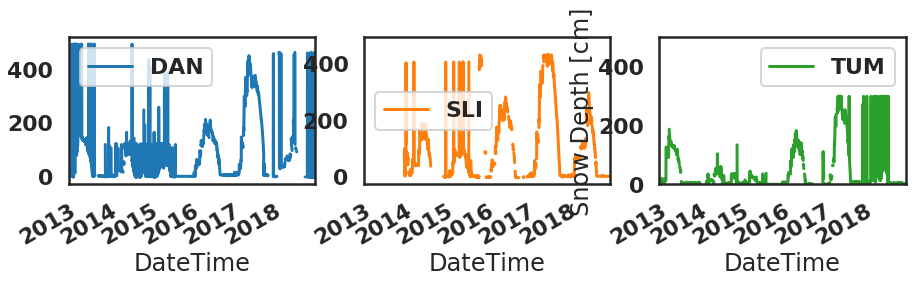

In [166]:
# merge snow depth [in] CSVs

# load single df, first in flist
df = pd.read_csv(flist[0], header=0, usecols=[0,1], names=['DateTime', flist[0].split("/")[-1][:3]])
df['DateTime'] = pd.to_datetime(df['DateTime']) #datetime dtype
df = df.set_index('DateTime') #set datatime as index

# add columns to df
for f in sorted(flist):  
    tmp_df = pd.read_csv(f, usecols=[0,1]) # load each csv as a tmp_df
    site_id = f.split("/")[-1][:3] #grab site id name from filename
    df.loc[:,site_id] = tmp_df['SNOW DP INCHES'].values # insert temp_df column into df at location (all rows, new site_id name)
    
df=df.replace('--', np.nan)  #raw data has '--' string to mark no value, replace w/ NANs
df=df.astype(float) #cast as float

df = df * 2.54 # convert raw [inches] to [cm] of snow
#note - data have a few negatives (-1,-2), but not too large...

#~~~~plot it
df.plot(subplots=True, layout=(1,3), figsize=(15,3))
plt.ylabel('Snow Depth [cm]')
plt.ylim(0,500)
plt.legend(loc='best')

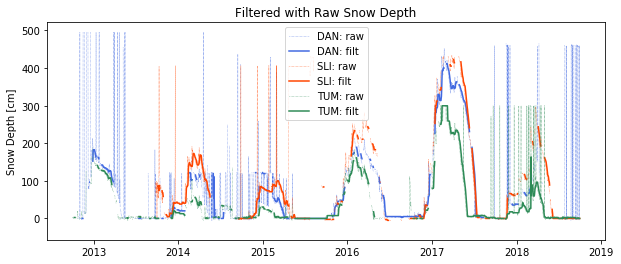

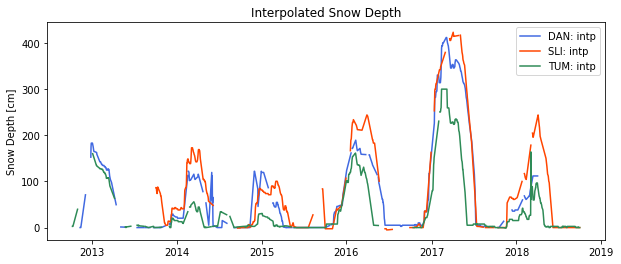

In [4]:
# Marks help
df_filt = df.copy() 
stations = list(df.columns)
colors = ['b','r','g']
colors = ['royalblue', 'orangered','seagreen']

# simple max filter
max_filter =  440
idx = df_filt > max_filter
df_filt[idx] = np.nan

# remove negatives
df_filt[(df_filt >= 0)]

# rolling median filter
df_filt = df_filt.rolling(10).median()

fig = plt.figure(figsize=(10,4))
a = plt.gca()

for i, stn in enumerate(stations):
    a.plot(df.index, df[stn].values,
           linewidth = 0.5,
           linestyle = ':',
           color = colors[i],
           label = '{}: raw'.format(stn))
    a.plot(df.index, df_filt[stn].values,
           color = colors[i],
           label = '{}: filt'.format(stn))

a.legend(loc='best')
a.set_title('Filtered with Raw Snow Depth')
a.set_ylabel('Snow Depth [cm]')
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#interpolate -- dangerous!
df_intp = df_filt.interpolate(method='linear', limit = 20)

fig = plt.figure(figsize=(10,4))
a = plt.gca()

for i, stn in enumerate(stations):
    a.plot(df_intp.index, df_intp[stn].values,
           color = colors[i],
           label = '{}: intp'.format(stn))
    
a.legend(loc='best')
a.set_title('Interpolated Snow Depth')
a.set_ylabel('Snow Depth [cm]')
plt.show()

#### Add lidar data





dana meadow
x direction length 6.0 [m]:
y direction length 6.0 [m]:
tuolumne meadow
x direction length 6.0 [m]:
y direction length 6.0 [m]:
slide canyon
x direction length 6.0 [m]:
y direction length 6.0 [m]:


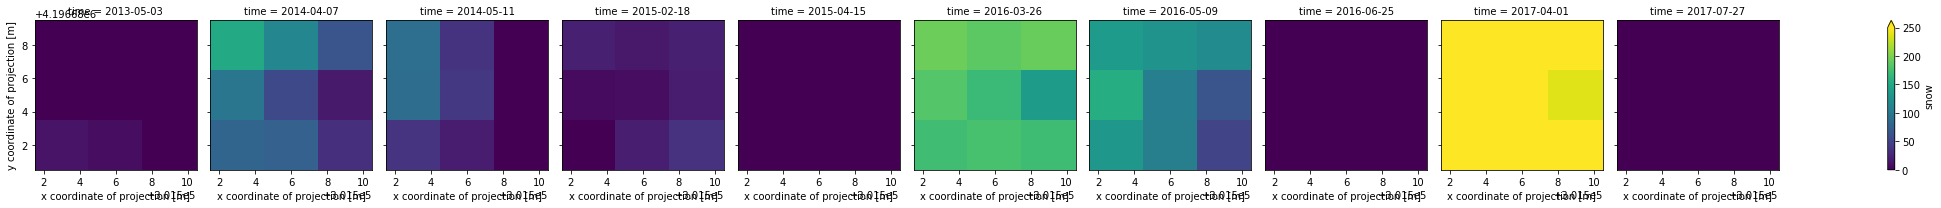

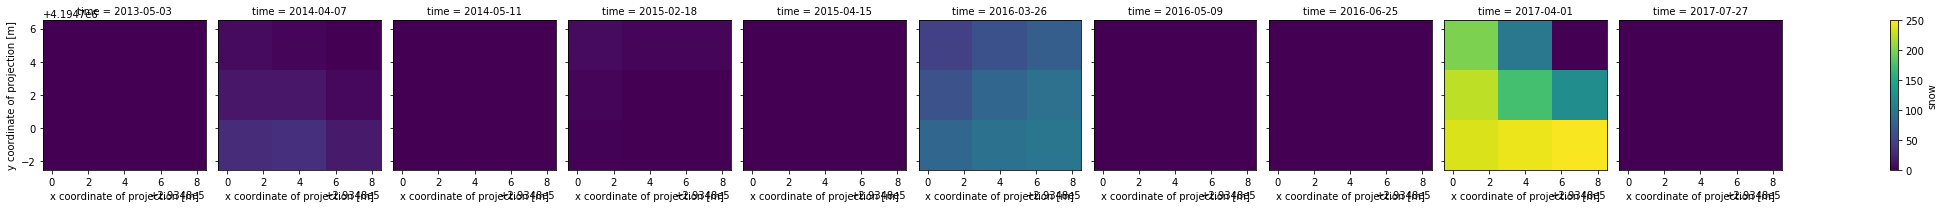

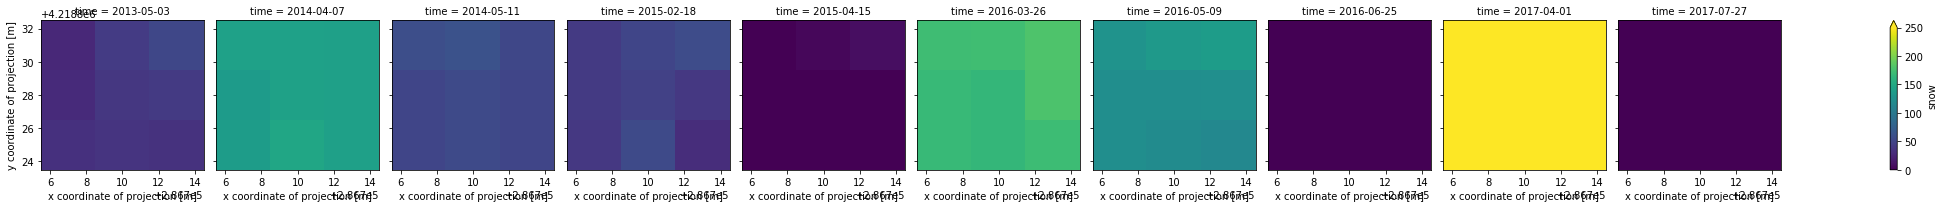

In [104]:
fname = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow.nc' #3m BSU
# fname = '/Users/megmason/research/sierra/data/compiled_SUPERsnow_20m.nc' #20m mac

#open data
ds = xr.open_dataset(fname, chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
ds=ds.astype(np.int16, copy=False)
ds.close()

#station slices
pix = 4 #multipy by 2 to get x and y distance of box sz
dan = ds.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89
tum = ds.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07
sli = ds.sel(x=slice(286709.-pix, 286710.+pix), y=slice(4218828.+pix, 4218827.-pix)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart

# dan.isel(time=32).snow.plot()
d = dan.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)
t = tum.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)
s = sli.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)

# d = dan.snow.plot(x='x', y='y', col='time', col_wrap=5, cmap='jet', cbar_kwargs={'label': 'snow depth [cm]'}); plt.show()

# snow_plot = ds.snow.plot(x='x', y='y', col='time', col_wrap=3,
#                          cmap='RdBu',
#             cbar_kwargs={'label': 'snow depth [cm]'})
# plt.minorticks_on()
# plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
# plt.gca().yaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
# plt.grid(which="both", linewidth=0.5,color="k")
# plt.tick_params(which="minor", length=0)
# plt.show()
print('dana meadow')
print('x direction length {} [m]:'.format(dan.x.max().values - dan.x.min().values))
print('y direction length {} [m]:'.format(dan.y.max().values - dan.y.min().values))
print('tuolumne meadow')
print('x direction length {} [m]:'.format(tum.x.max().values - tum.x.min().values))
print('y direction length {} [m]:'.format(tum.y.max().values - tum.y.min().values))
print('slide canyon')
print('x direction length {} [m]:'.format(sli.x.max().values - sli.x.min().values))
print('y direction length {} [m]:'.format(sli.y.max().values - sli.y.min().values))

In [105]:
print(dan)

<xarray.Dataset>
Dimensions:  (time: 51, x: 3, y: 3)
Coordinates:
  * y        (y) float64 4.197e+06 4.197e+06 4.197e+06
  * x        (x) float64 3.015e+05 3.015e+05 3.015e+05
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(3, 3), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
    srf      (y, x) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>


In [ ]:
#save station boxes at netCDFs
# dan.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_150m_dan.nc')
# tum.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_150m_tum.nc')
# sli.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_150m_sli.nc')


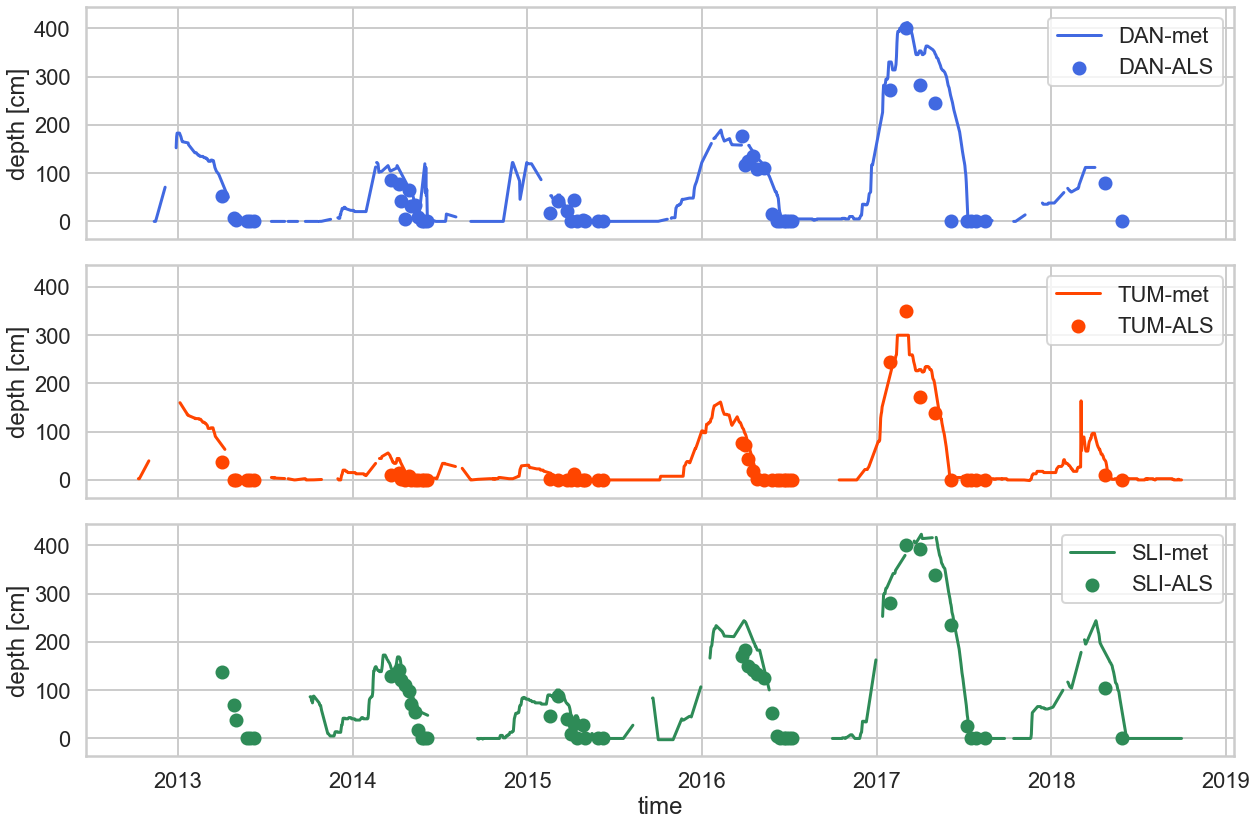

In [149]:
#mean snow depth in 15m x 15m boxes
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey=True, figsize=(18,12))

#ax1 = DAN
ax1.plot(df_intp.index, df_intp['DAN'].values, label = 'DAN-met', color='royalblue') #interpolated dataframe of station snow depth
dan.mean(dim=('x','y')).plot.scatter(x='time', y='snow', color='royalblue', 
                                     label='DAN-ALS', ax=ax1); ax1.legend(); ax1.set_ylabel('depth [cm]'), ax1.set_xlabel('') #mean snow depth of lidar for each station box over time (15m x15m)
#ax2 = TUM
ax2.plot(df_intp.index, df_intp['TUM'].values, label = 'TUM-met', color='orangered')
tum.mean(dim=('x','y')).plot.scatter(x='time', y='snow', color='orangered', 
                                     label='TUM-ALS', ax=ax2); ax2.legend(); ax2.set_ylabel('depth [cm]'), ax2.set_xlabel('')
#ax3 = SLI
ax3.plot(df_intp.index, df_intp['SLI'].values, label = 'SLI-met', color='seagreen')
sli.mean(dim=('x','y')).plot.scatter(x='time', y='snow', color='seagreen', 
                                     label='SLI-ALS', ax=ax3); ax3.legend(); ax3.set_ylabel('depth [cm]')
plt.tight_layout()
plt.savefig('../figs/validate_lidar_at_stations', dpi=300)


#### compute RMSD and plot one-to-one for Met Stations vs ALS (9x9m area)

In [107]:
dstr = pd.to_datetime(dan.time.values) #date string from ALS flight dates
df_comp = df_intp.loc[dstr] #DataFrame to COMPare, pulls met station dates that overlap ALS dates   :) #buy pickels!
df_comp.rename(columns = {'DAN': 'DAN_met', 'SLI': 'SLI_met', 'TUM': 'TUM_met'}, inplace=True) #rename df columns to specify met station values
df_comp['DAN_als'] = dan.snow.mean(dim=('x','y')).values #add DAN-als
df_comp['TUM_als'] = tum.snow.mean(dim=('x','y')).values #add TUM-als
df_comp['SLI_als'] = sli.snow.mean(dim=('x','y')).values #add SLI-als

In [150]:
#rmsd and r
# rmsd = sqrt(mean_squared_error(y_actual, y_predicted)) #template for RMSD
# r = pearsonr(y_actual, y_predicted) #template for r
#dan
ix = pd.notnull(df_comp['DAN_met'])
d_rmsd = sqrt(mean_squared_error(df_comp['DAN_met'][ix], df_comp['DAN_als'][ix]))
d_r =  pearsonr(df_comp['DAN_met'][ix], df_comp['DAN_als'][ix])[0]
#tum
ix = pd.notnull(df_comp['TUM_met'])
t_rmsd = sqrt(mean_squared_error(df_comp['TUM_met'][ix], df_comp['TUM_als'][ix]))
t_r =  pearsonr(df_comp['TUM_met'][ix], df_comp['TUM_als'][ix])[0]
#sli
ix = pd.notnull(df_comp['SLI_met'])
s_rmsd = sqrt(mean_squared_error(df_comp['SLI_met'][ix], df_comp['SLI_als'][ix]))
s_r =  pearsonr(df_comp['SLI_met'][ix], df_comp['SLI_als'][ix])[0]

rmsd = [d_rmsd, t_rmsd, s_rmsd]
r = [d_r, t_r, s_r]
print('RMSD:', rmsd)
print('R:', r)

RMSD: [58.413415558176226, 21.81061651786312, 37.82432521481395]
R: [0.8921914550146288, 0.9629021363682422, 0.9742882151650332]


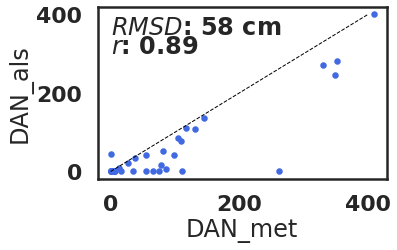

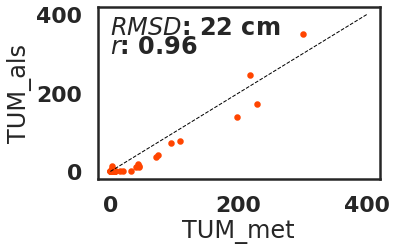

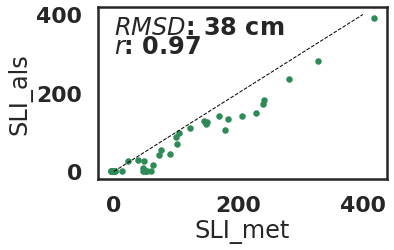

In [167]:
#dan
df_comp.plot.scatter(x='DAN_met', y='DAN_als', c='royalblue')
plt.plot([0, 400], [0, 400], '--k', linewidth = 1)
txt_rmsd = plt.annotate('$RMSD$: {:.0f} cm'.format(d_rmsd),
                                     xy=(0,350))
txt_r = plt.annotate('$r$: {:.2f}'.format(d_r),
                                     xy=(0,300))
plt.tight_layout()
plt.savefig('../figs/dan_validate', dpi=300)

#tum
df_comp.plot.scatter(x='TUM_met', y='TUM_als', c='orangered')
plt.plot([0, 400], [0, 400], '--k', linewidth = 1)
txt_rmsd = plt.annotate('$RMSD$: {:.0f} cm'.format(t_rmsd),
                                     xy=(0,350))
txt_r = plt.annotate('$r$: {:.2f}'.format(t_r),
                                     xy=(0,300))
plt.tight_layout()
plt.savefig('../figs/tum_validate', dpi=300)

#sli
df_comp.plot.scatter(x='SLI_met', y='SLI_als', c='seagreen')
plt.plot([0, 400], [0, 400], '--k', linewidth = 1)
txt_rmsd = plt.annotate('$RMSD$: {:.0f} cm'.format(s_rmsd),
                                     xy=(0,350))
txt_r = plt.annotate('$r$: {:.2f}'.format(s_r),
                                     xy=(0,300))
plt.tight_layout()
plt.savefig('../figs/sli_validate', dpi=300)


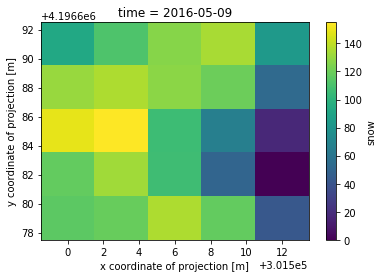

In [78]:
tum

#### EXTRA STUFF BELOW

In [ ]:
# attempt to clean data with IQR

# df_clean = pd.DataFrame().reindex_like(df)
# water_years=list(range(2012,2019))

# for wy in water_years:
#     df_wy = df.loc['{}-10-01'.format(wy) : '{}-09-30'.format(wy+1)]
# #     print(data.index)
    
#     #compute the inner-quartile range (5-95% of data)
#     Q1 = df_wy.quantile(0.05)
#     Q3 = df_wy.quantile(0.95)
# #     IQR = Q3 - Q1

#     #remove outliers
#     df_tmp = df_wy[(df_wy > Q1) & (df_wy < Q3)] #everything between the IQR
#     df_tmp = df_tmp[(df_tmp >= 0)] #remove negatives
#     print('YEAR:', wy)
# #     print(df.max())
# #     print(df_tmp.max())
#     print(df_tmp)
#     print('MINI CLEAN', df_clean)
# #     df.plot()
# #     df_wy.plot()
#     df_clean.append(df_tmp)
# # print('RAW\n', df.max(), df.min()) #df (raw)
# # print('\nCLEAN\n', df_clean.max(), df_clean.min()) # df_clean

# df_clean.plot()


In [ ]:
# #compute the inner-quartile range (5-95% of data)
# Q1 = df.quantile(0.05)
# Q3 = df.quantile(0.95)
# IQR = Q3 - Q1

# #remove outliers
# df_out = df[(df > Q1) & (df < Q3)] #everything between the IQR
# df_out = df_out[(df_out >= 0)] #remove negatives
# print('OG\n', df.max(), df.min()) #df (raw)
# print('\nOUT\n', df_out.max(), df_out.min()) # df_out (clean)

# #ref: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [ ]:
df.boxplot()

In [ ]:
#extra stuff...
boo = pd.DataFrame(np.random.randint(0,5,size=(10, 4)), columns=list('ABCD'))
boo.dtypes
boo

boo.replace(0, 'bla', inplace=True)
boo